## 从在线时长和充值两个维度对用户进行。并分析不同用户群上述指标情况。

## 导库

In [1]:
import numpy as np
import pandas as pd
from typing import Dict, List
import time;
from datetime import datetime
import duckdb;
import matplotlib.pyplot as plt
# import seaborn as sns
from matplotlib.ticker import FuncFormatter
import seaborn as sns  # 导入 seaborn，基于 matplotlib 的可视化库，支持更美观的统计图表
from sklearn.preprocessing import StandardScaler

# 设置中文字体支持
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'DejaVu Sans']  # 按优先级尝试
plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号





## 从数据库读取表数据

In [2]:
#获取duckdb数据库中的表数据
def getTableData(db_path, tables) -> Dict[str, pd.DataFrame]:
    dataframes = {}
    conn = duckdb.connect(database=db_path, read_only=True)
    for tableName in tables:
        df = conn.execute(f"SELECT * FROM ga2_dwd_v2.{tableName}").df()
        dataframes[tableName] = df
    conn.close()
    return dataframes


# 读取数据
result = getTableData(r'data/game_analysis_v2.duck', ['dim_role', 'fact_player_login_recharge'])
dim_role = result["dim_role"]    #角色表
fact_player_login_recharge = result["fact_player_login_recharge"]  #登录和充值表

## 查看表数据

In [3]:
dim_role.shape, fact_player_login_recharge.shape

((373596, 11), (693996, 29))

In [4]:
fact_player_login_recharge.head(2)

,rid,name,min_lv,max_lv,stat_date,continue_login_date_cnt,login_cnt,logout_cnt,cause_0_cnt,cause_1_cnt,...,charge_yuanbao,coupon_cnt,coupon_money,coupon_yuanbao,useticket_cnt,useticket_money,useticket_yuanbao,normal_cnt,normal_money,normal_yuanbao
0,R13123717089387341,d240ee50b128eeff17ed9da8476b80d2,0,0,2024-02-26,1,1,1,1,0,...,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN
1,R13123717089387691,cf09309736016d630f3eec0a43b1c35b,0,0,2024-02-26,1,2,2,2,0,...,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN


In [5]:
fact_player_login_recharge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693996 entries, 0 to 693995
Data columns (total 29 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   rid                      693996 non-null  object 
 1   name                     693996 non-null  object 
 2   min_lv                   693996 non-null  int32  
 3   max_lv                   693996 non-null  int32  
 4   stat_date                693996 non-null  object 
 5   continue_login_date_cnt  693996 non-null  int64  
 6   login_cnt                693996 non-null  int64  
 7   logout_cnt               693996 non-null  int64  
 8   cause_0_cnt              693996 non-null  int64  
 9   cause_1_cnt              693996 non-null  int64  
 10  online_time_sec          693996 non-null  float64
 11  real_cnt                 60853 non-null   Int64  
 12  real_money               60853 non-null   float64
 13  real_yuanbao             60853 non-null   float64
 14  orde

In [6]:
fact_player_login_recharge.isnull().sum()

rid                             0
name                            0
min_lv                          0
max_lv                          0
stat_date                       0
continue_login_date_cnt         0
login_cnt                       0
logout_cnt                      0
cause_0_cnt                     0
cause_1_cnt                     0
online_time_sec                 0
real_cnt                   633143
real_money                 633143
real_yuanbao               633143
order_cnt                  633143
order_money                633143
order_yuanbao              633143
charge_cnt                 633143
charge_money               633143
charge_yuanbao             633143
coupon_cnt                 633143
coupon_money               633143
coupon_yuanbao             633143
useticket_cnt              633143
useticket_money            633143
useticket_yuanbao          633143
normal_cnt                 633143
normal_money               633143
normal_yuanbao             633143
dtype: int64

In [7]:
desc = fact_player_login_recharge.describe()
print(desc)
desc.to_clipboard(excel=True)
print("已复制到剪贴板：可直接 Ctrl+V 粘贴到 Excel")


              min_lv         max_lv  continue_login_date_cnt      login_cnt  \
count  693996.000000  693996.000000            693996.000000  693996.000000   
mean       31.469985      31.557646                64.354813      12.523721   
std        65.573364      65.658413               121.053696      21.645773   
min         0.000000       0.000000                 1.000000       0.000000   
25%         0.000000       0.000000                 1.000000       1.000000   
50%         0.000000       0.000000                 6.000000       4.000000   
75%         0.000000       0.000000                66.000000      15.000000   
max       220.000000     220.000000               700.000000     826.000000   

          logout_cnt    cause_0_cnt    cause_1_cnt  online_time_sec  real_cnt  \
count  693996.000000  693996.000000  693996.000000    693996.000000   60853.0   
mean       12.523687      11.715131       0.671118      9031.420047  3.442854   
std        21.646571      20.667786       2.9

## 理解数据

<Figure size 1500x1000 with 0 Axes>

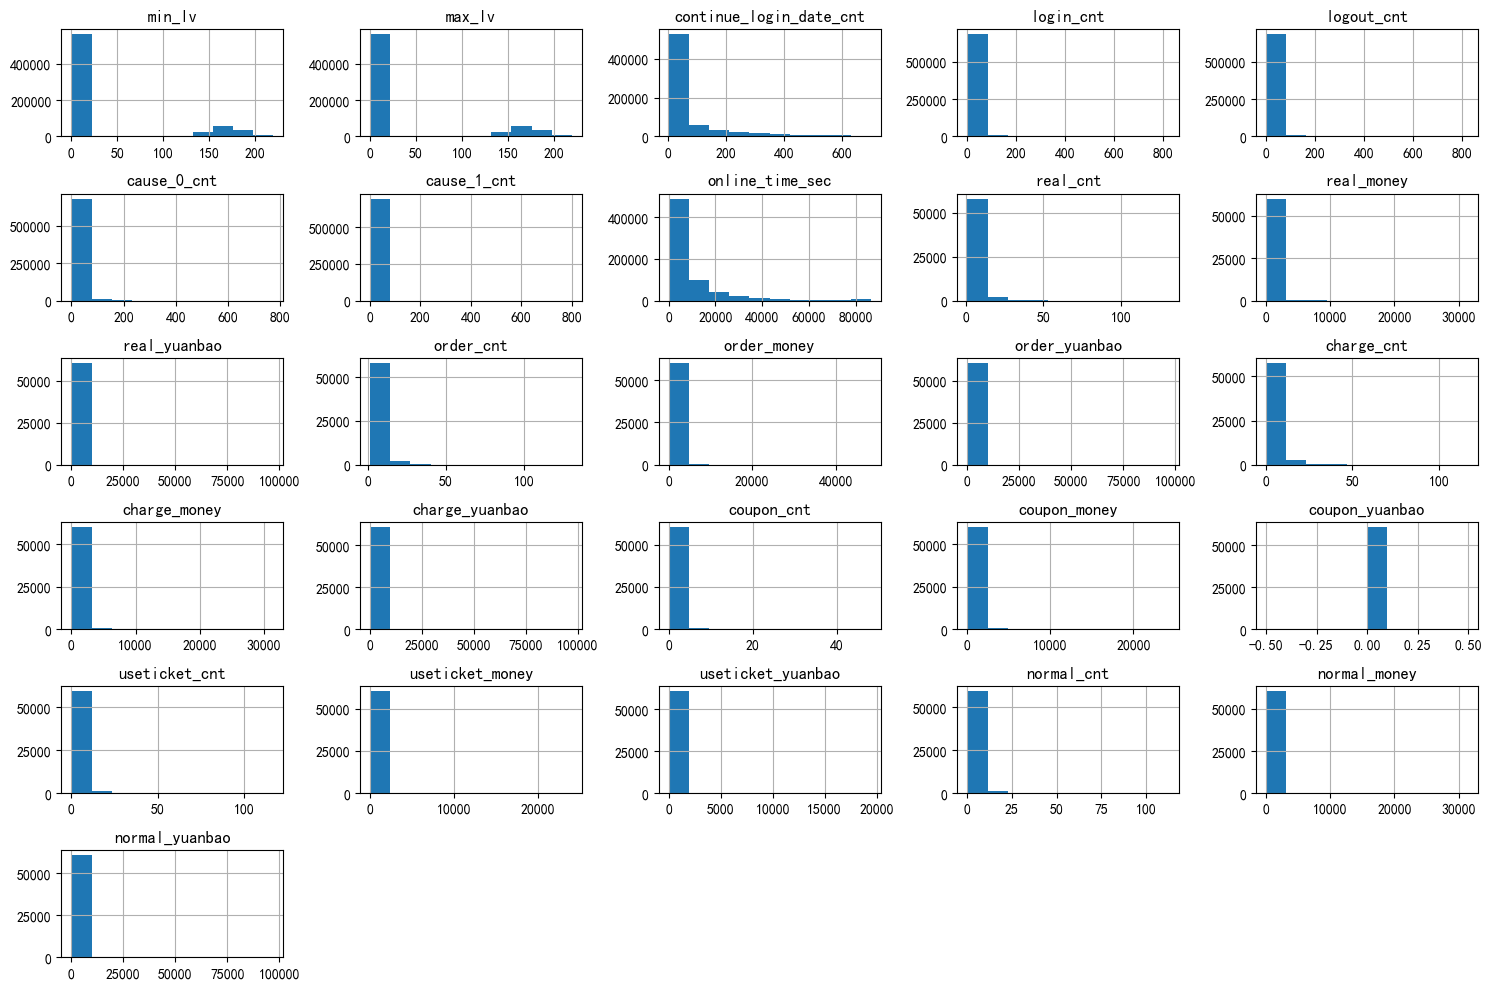

In [8]:
plt.figure(figsize=(15,10))  # 设置画布大小，宽15英寸，高10英寸
fact_player_login_recharge.hist(figsize=(15,10))  # 也可以直接在hist里设置figsize
plt.tight_layout()  # 自动调整子图间距，避免重叠
plt.show()

## 聚焦关注的指标

In [9]:
df_duamoney=fact_player_login_recharge[['rid','online_time_sec','real_money']].groupby('rid').sum().reset_index()
df_duamoney.isnull().sum()

rid                0
online_time_sec    0
real_money         0
dtype: int64

In [10]:
df_duamoney.describe()

,online_time_sec,real_money
count,2.259540e+05,2.259540e+05
mean,2.773914e+04,5.812055e+01
std,5.535139e+05,4.511069e+03
min,0.000000e+00,0.000000e+00
25%,5.400000e+01,0.000000e+00
50%,2.610000e+02,0.000000e+00
75%,8.937500e+02,0.000000e+00
max,5.315962e+07,1.244950e+06


👆玩家行为呈现 严重右偏 + 长尾   <mark>极端长尾</mark> <br>
大多数人：
    玩得少
    不付费<br>
极少数人：
    玩得非常久
    贡献了几乎全部收入

In [11]:
df_duamoney['real_money'].quantile([0.5, 0.75, 0.8, 0.9, 0.95, 0.99])

0.50      0.0
0.75      0.0
0.80      0.0
0.90      0.0
0.95      0.0
0.99    134.0
Name: real_money, dtype: float64

👆通过分位数可以看到，只有最“顶部 1%”的玩家充值金额 > 78 元

In [12]:
df_duamoney['online_time_hour'] = df_duamoney['online_time_sec'] / 3600

print(df_duamoney['online_time_hour'] \
      .quantile([0.5, 0.75, 0.8, 0.9, 0.95, 0.99]))


0.50     0.072500
0.75     0.248264
0.80     0.423056
0.90     1.793611
0.95     4.791861
0.99    72.816056
Name: online_time_hour, dtype: float64


## 特征缩放

In [13]:
# 1)取对数
df_duamoney['log_online_time_sec'] = np.log1p(df_duamoney['online_time_sec'])
df_duamoney['log_real_money'] = np.log1p(df_duamoney['real_money'])

# 2) 标准化：对 log 后的列做（更符合聚类场景）
scaler = StandardScaler()
z_cols = ['log_online_time_sec', 'log_real_money']
Z = scaler.fit_transform(df_duamoney[z_cols])

df_duamoney['z_log_online_time_sec'] = Z[:, 0]
df_duamoney['z_log_real_money'] = Z[:, 1]


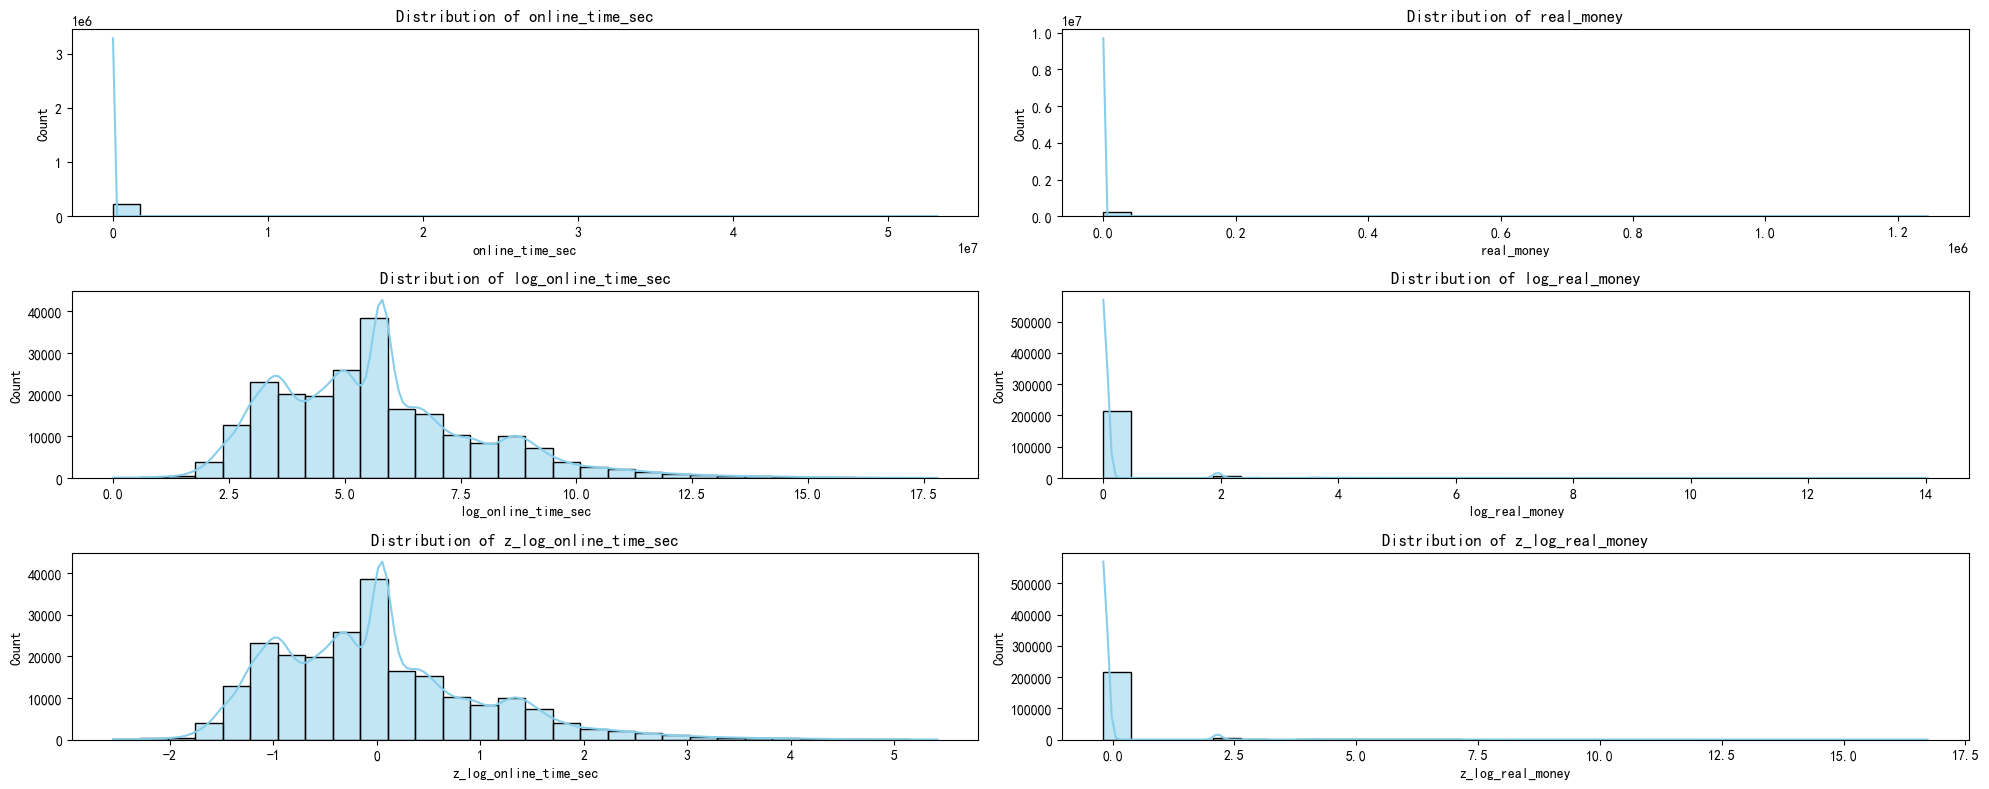

In [14]:
plt.figure(figsize=(20, 8))  # 设置画布大小
plotnumber = 1  # 初始化子图序号
# 遍历6个数值特征
for col in ['online_time_sec', 'real_money','log_online_time_sec', 'log_real_money', 'z_log_online_time_sec', 'z_log_real_money']:
    if plotnumber <= 12:
        ax = plt.subplot(3, 2, plotnumber)  # 创建 3 行 2 列中的第 plotnumber 个子图
        sns.histplot(df_duamoney[col], kde=True, bins=30, color='skyblue')  # 画直方图并叠加 KDE 曲线
        plt.title(f'Distribution of {col}')  # 添加标题
    plotnumber += 1

plt.tight_layout()  # 自动调整子图间距
plt.show()  # 显示图像

👆 取对数，改变分布形状（压缩长尾）<br>
    标准化，不改形状，只改坐标。标准化是在“让算法公平计算距离”

In [15]:
print(df_duamoney[['z_log_online_time_sec', 'z_log_real_money']].mean())
print(df_duamoney[['z_log_online_time_sec', 'z_log_real_money']].std())


z_log_online_time_sec   -4.135823e-16
z_log_real_money        -4.025132e-18
dtype: float64
z_log_online_time_sec    1.000002
z_log_real_money         1.000002
dtype: float64


👆对在线时长和充值金额等右偏特征进行对数变换后，采用 Z-score 方法进行标准化处理。经验证，标准化后的特征均值接近 0、标准差接近 1，说明标准化过程有效，可用于后续基于距离的聚类分析。

## 肘部法 选K值

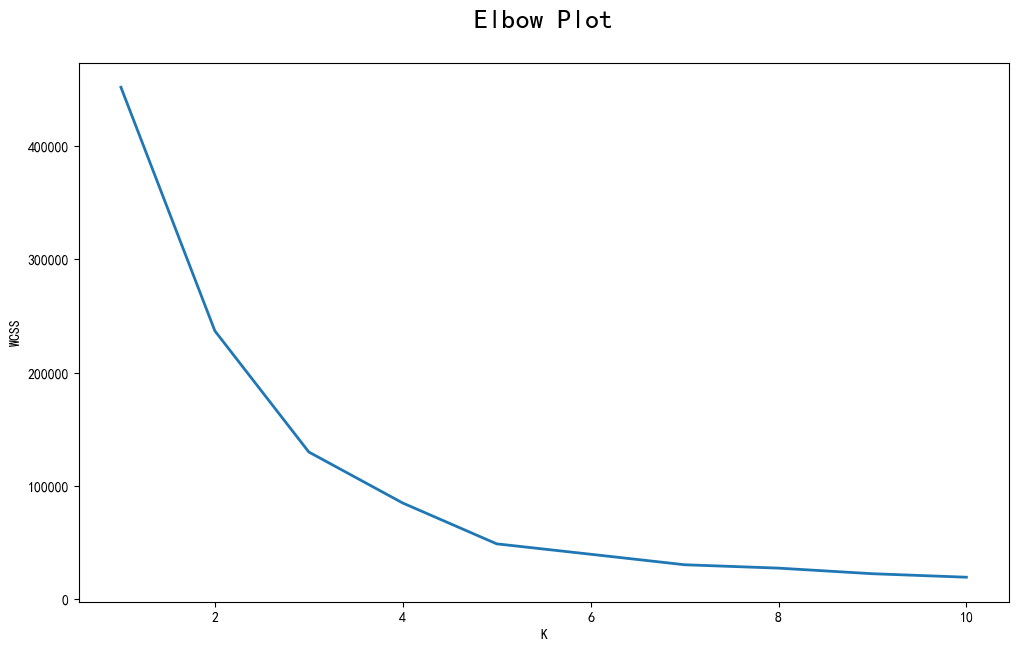

In [16]:
from sklearn.cluster import KMeans
X3 = df_duamoney.loc[:, ['z_log_online_time_sec', 'z_log_real_money']].values

wcss= []
for k in range(1, 11):
    kmeans = KMeans(n_clusters = k, init = 'k-means++')
    kmeans.fit(X3)
    wcss.append(kmeans.inertia_)

plt.figure(figsize = (12, 7))

plt.plot(range(1, 11), wcss, linewidth = 2)
plt.title('Elbow Plot\n', fontsize = 20)
plt.xlabel('K')
plt.ylabel('WCSS')
plt.show()

👆采用肘部法对不同 K 值下的类内平方和（WCSS）进行比较。结果显示，当 K 从 1 增加到 4 时，WCSS 下降幅度较大，而 K ≥ 5 后下降趋势明显放缓，说明继续增加聚类数的边际收益有限。因此，综合模型复杂度与可解释性，最终选择 K = 4 作为聚类数。

## Step 1：准备聚类输入 X（用 z_log 特征）

In [17]:
# 1) 选择用于聚类的特征：用标准化后的 log 特征（最稳）
cluster_features = ['z_log_online_time_sec', 'z_log_real_money']

# 2) 取出 X，并处理缺失/异常
X = df_duamoney[cluster_features].copy()
print("原始 X shape:", X.shape)
print("缺失值统计：")
print(X.isna().sum())

df_km = X.dropna().copy()  # 删除缺失值所在行
print("\n清洗后 X shape:", X.shape)
print("df_km shape:", df_km.shape)
print("用于聚类的特征列：", cluster_features)
print("\nX.describe()：")
print(X.describe())

原始 X shape: (225954, 2)
缺失值统计：
z_log_online_time_sec    0
z_log_real_money         0
dtype: int64

清洗后 X shape: (225954, 2)
df_km shape: (225954, 2)
用于聚类的特征列： ['z_log_online_time_sec', 'z_log_real_money']

X.describe()：
       z_log_online_time_sec  z_log_real_money
count           2.259540e+05      2.259540e+05
mean           -4.135823e-16     -4.025132e-18
std             1.000002e+00      1.000002e+00
min            -2.549615e+00     -1.906910e-01
25%            -7.550326e-01     -1.906910e-01
50%            -5.597306e-02     -1.906910e-01
75%             4.940452e-01     -1.906910e-01
max             5.416654e+00      1.672500e+01


## Step 2：固定 K=4 跑 KMeans，并把 cluster 写回 df

In [18]:
from sklearn.cluster import KMeans

k = 4
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)

clusters = kmeans.fit_predict(X)
df_duamoney['cluster_2d'] = clusters

print("聚类完成。cluster 分布：")
print(df_duamoney['cluster_2d'].value_counts().sort_index())
print("\ncluster 占比：")
print(df_duamoney['cluster_2d'].value_counts(normalize=True).sort_index())

聚类完成。cluster 分布：
cluster_2d
0    111147
1    103842
2      2776
3      8189
Name: count, dtype: int64

cluster 占比：
cluster_2d
0    0.491901
1    0.459571
2    0.012286
3    0.036242
Name: proportion, dtype: float64


## Step 3：可视化

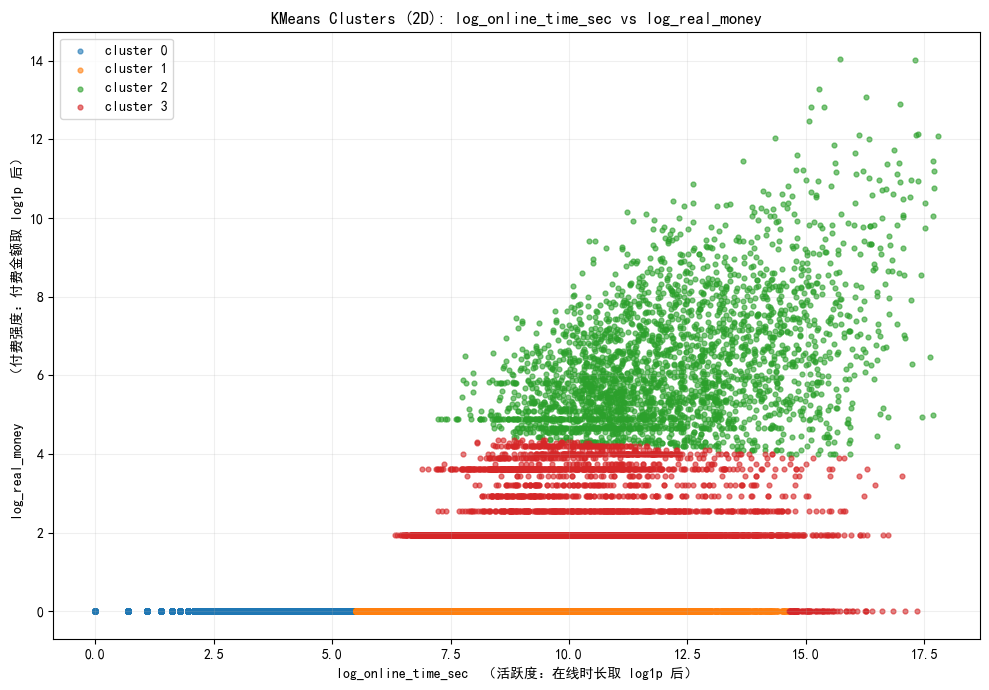

In [19]:
# =========================
# 4) 可视化：直接用原始二维含义（更好解释）
#    注意：画图用原始 log 特征，更直观
# =========================
plt.figure(figsize=(10, 7))

for label in range(k):
    idx = (clusters == label)
    plt.scatter(
        df_duamoney.loc[idx, 'log_online_time_sec'],
        df_duamoney.loc[idx, 'log_real_money'],
        s=12,
        alpha=0.6,
        label=f'cluster {label}'
    )

plt.title('KMeans Clusters (2D): log_online_time_sec vs log_real_money')
plt.xlabel('log_online_time_sec  （活跃度：在线时长取 log1p 后）')
plt.ylabel('log_real_money      （付费强度：付费金额取 log1p 后）')
plt.legend()
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()


## Step 4：输出每一类的“画像统计”
这里我们输出三张关键表：
人数（count）

付费用户数（real_money>0）

均值/中位数画像（在线、付费）

In [20]:
# =========================
# 每一类用户画像（用原始指标解释，更符合业务）
# =========================
profile = (
    df_duamoney
    .groupby('cluster_2d')[['online_time_sec', 'real_money']]
    .agg(['count', 'mean', 'median', 'sum'])
)

print("\n各簇画像（count/mean/median/sum）：")
print(profile)


各簇画像（count/mean/median/sum）：
           online_time_sec                                       real_money  \
                     count          mean    median           sum      count   
cluster_2d                                                                    
0                   111147  7.640785e+01      53.0  8.492503e+06     111147   
1                   103842  7.452122e+03     717.0  7.738433e+08     103842   
2                     2776  1.442844e+06  145989.0  4.005335e+09       2776   
3                     8189  1.807423e+05   15774.0  1.480099e+09       8189   

                                            
                   mean median         sum  
cluster_2d                                  
0              0.000000    0.0         0.0  
1              0.000000    0.0         0.0  
2           4695.809798  360.0  13035568.0  
3             11.845402    6.0     97002.0  


## 👆以上图表含义:“活跃 × 付费”二维用户空间。
 C0（cluster 0，右下长条）:高活跃不付费用户.人数：6987,平均在线时长 mean：15336(4.26小时)<br>
 C1（cluster 1，左下）:低活跃 · 非付费用户.人数：12488,在线时长 median：28秒,real_money：全 0.大量用户几乎没有留下来，是典型“注册后即流失”人群。<br>
C2（cluster 2，中右）:活跃 · 轻/中度付费用户。人数：557，平均充值10.94元，充值中位数是6元。已经完成“首充 + 复购”的用户，是运营提升 ARPU 的核心人群。<br>
C3（cluster 3，右上）:核心高价值 。人数：211，平均在线时长7.4 天，平均充值3685元，充值中位数342.。极少数用户贡献了极高的收入，是重点维护对象。<br>

基于用户活跃度（log_online_time_sec）与付费强度（log_real_money）两个维度进行 KMeans 聚类分析，结果将用户划分为四类：低活跃非付费用户、高活跃非付费用户、活跃轻度付费用户及核心高价值用户。
其中，核心高价值用户数量占比极低，但贡献了主要收入；高活跃非付费用户数量可观，具备较强的转化潜力。该分层结果为后续差异化运营策略制定提供了数据依据。


## Step 5：画「人数占比 vs 收入占比」对比柱状图

   cluster_2d  user_count  revenue_sum  user_ratio  revenue_ratio
0           0      111147          0.0    0.491901       0.000000
1           1      103842          0.0    0.459571       0.000000
2           2        2776   13035568.0    0.012286       0.992614
3           3        8189      97002.0    0.036242       0.007386


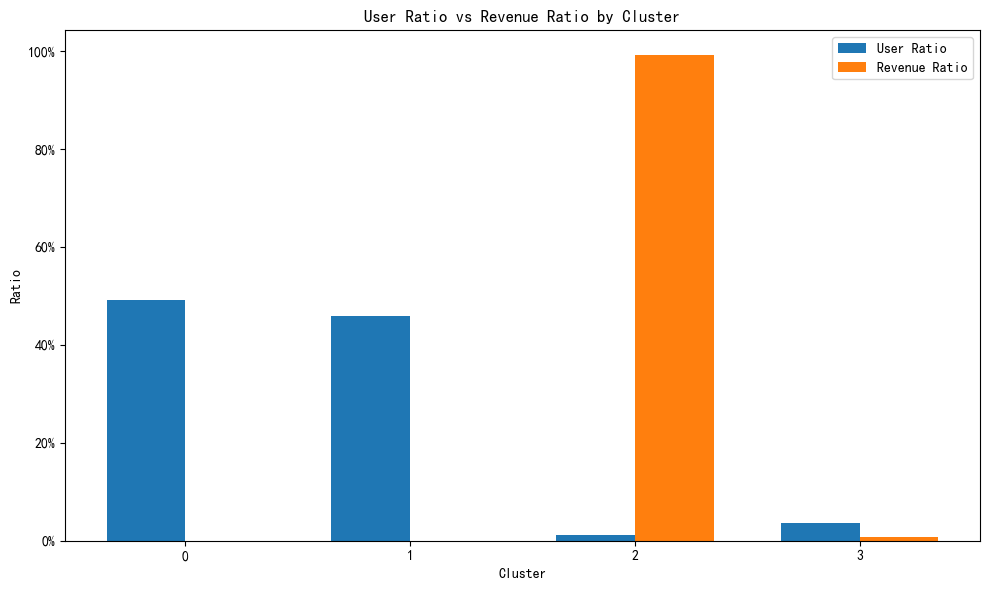

In [21]:

# 1. 按 cluster 聚合：人数 + 总收入
cluster_summary = (
    df_duamoney
    .groupby('cluster_2d')
    .agg(
        user_count=('cluster_2d', 'count'),
        revenue_sum=('real_money', 'sum')
    )
    .reset_index()
)

# 2. 计算占比
cluster_summary['user_ratio'] = (
    cluster_summary['user_count'] / cluster_summary['user_count'].sum()
)

cluster_summary['revenue_ratio'] = (
    cluster_summary['revenue_sum'] / cluster_summary['revenue_sum'].sum()
)

print(cluster_summary)



# 3. 画对比柱状图
x = np.arange(len(cluster_summary))  # cluster 的位置
width = 0.35  # 每根柱子的宽度

plt.figure(figsize=(10, 6))

# 人数占比
plt.bar(
    x - width / 2,
    cluster_summary['user_ratio'],
    width,
    label='User Ratio'
)

# 收入占比
plt.bar(
    x + width / 2,
    cluster_summary['revenue_ratio'],
    width,
    label='Revenue Ratio'
)

plt.xticks(x, cluster_summary['cluster_2d'])
plt.xlabel('Cluster')
plt.ylabel('Ratio')
plt.title('User Ratio vs Revenue Ratio by Cluster')

# y 轴显示为百分比
plt.gca().yaxis.set_major_formatter(
    lambda y, _: f'{y:.0%}'
)

plt.legend()
plt.tight_layout()
plt.show()



👆从人数分布与收入贡献的对比可以看出，用户价值呈现高度不均衡特征。
大多数用户集中在低付费或非付费分层，对整体收入贡献有限；而少量高价值用户虽然占比极低，却贡献了绝大部分收入，体现出明显的二八效应。
因此，在用户运营策略上，应对高价值用户进行重点维护，同时针对中度付费用户设计精细化转化路径

# 基于 KMeans 的游戏用户分层分析结论

## 一、总体结论

基于用户在线活跃度（`online_time_sec`）与实际充值金额（`real_money`）两个核心指标，在对特征进行对数变换（log1p）与标准化处理后，采用 KMeans 聚类方法对用户进行分群分析。通过肘部法（Elbow Method）确定聚类数为 **K = 4**，最终将用户划分为四类具有显著差异的用户群体。

聚类结果表明，用户在活跃度与付费行为上呈现出明显的结构性分层特征，不同用户群体在用户规模与收入贡献方面存在显著不均衡现象。

---

## 二、用户分群画像分析

### Cluster 0：高活跃 · 非付费用户（活跃白嫖用户）

**数据特征：**
- 用户数：6987（约 34%）
- 在线时长中位数：761 秒（约 0.21 小时）
- 实际充值金额：均值 / 中位数 / 总额均接近 0
- 收入贡献占比：约 0%

**业务解读：**  
该类用户具有较高的活跃度，但尚未产生任何实际付费行为，是典型的“高活跃非付费用户”群体。这类用户对游戏内容有较强参与意愿，但在付费转化环节存在明显阻碍。

**用户标签：**  
> 活跃白嫖用户

---

### Cluster 1：低活跃 · 非付费用户（路过型用户）

**数据特征：**
- 用户数：12488（约 61%）
- 在线时长中位数：28 秒
- 几乎无任何付费行为
- 收入贡献占比：约 0%

**业务解读：**  
该类用户数量最多，但活跃度极低，付费行为几乎不存在，属于典型的“路过型用户”或潜在流失用户，对整体收入贡献有限。

**用户标签：**  
> 路过型用户 / 高流失风险用户

---

### Cluster 2：中高活跃 · 轻度付费用户（潜力用户）

**数据特征：**
- 用户数：557（约 2.7%）
- 在线时长中位数：25652 秒（约 7.1 小时）
- 实际充值金额中位数：6
- 收入贡献占比：约 0.8%

**业务解读：**  
该类用户具有较高活跃度，并已完成初步付费转化，但单用户付费金额较低，属于具备明显成长潜力的轻度付费用户群体。

**用户标签：**  
> 潜力付费用户（轻 R）

---

### Cluster 3：极高活跃 · 高付费用户（核心高价值用户）

**数据特征：**
- 用户数：211（约 1%）
- 在线时长中位数：20551 秒（约 5.7 小时）
- 实际充值金额中位数：342
- **收入贡献占比：约 99%**

**业务解读：**  
尽管该类用户在整体用户规模中占比极低，但却贡献了绝大多数游戏收入，是游戏的核心营收来源。这一结果体现了游戏用户收入分布的高度集中性特征。

**用户标签：**  
> 核心高价值用户（大 R / 鲸鱼用户）

---

## 三、关键业务洞察

### 洞察一：用户规模与收入贡献高度不匹配  
超过 95% 的用户未产生任何实际收入，而不足 2% 的用户贡献了几乎全部游戏收入，呈现出明显的“二八效应”甚至更为极端的幂律分布特征。

### 洞察二：活跃是付费的必要但非充分条件  
高活跃用户群体中仍存在大量未付费用户，说明单纯提升用户活跃度并不能保证付费转化，仍需结合付费动机与机制设计。

### 洞察三：高价值用户具备可识别的行为特征  
高付费用户在在线时长和活跃度上显著高于其他群体，说明可基于行为特征对高价值用户进行提前识别与重点维护。

---

## 四、运营与分析建议

### 建议一：差异化用户运营策略
- **Cluster 1（路过型用户）**：优化新手引导，降低早期流失
- **Cluster 0（活跃白嫖用户）**：设计低门槛付费点（如首充、限时礼包）
- **Cluster 2（潜力付费用户）**：通过成长型礼包和阶段奖励提升 ARPU
- **Cluster 3（高价值用户）**：重点维护，提供专属权益和高阶内容

### 建议二：将聚类结果作为后续建模特征  
本次聚类得到的用户分群标签可作为用户画像特征，引入后续的付费预测或流失预测模型中，以提升模型的业务解释能力。

---

## 五、总结

本研究通过聚类分析方法，从用户行为和付费角度系统识别了具有显著差异的用户群体结构，验证了游戏用户价值分布的高度不均衡性。分析结果不仅揭示了不同用户群体的行为特征，也为后续精细化运营和用户价值管理提供了数据支持。
